# QueryTranslation
QueryTranslationとは修正したQueryを使って文章検索をする手法です。

今日はStep back promptingとRewrite-Retrieve-Read の二つのQueryTranslationの手法と複数のクエリ生成するMulti Queryを紹介します。



### Step back prompting
ユーザーの質問をより広い視野(Step back)で捉えた文章に変換してRetrieverに渡す方法です。

### Rewrite-Retrieve-Read 
ユーザーの質問を検索に適した文章に書き換える方法です。例えばユーザーの質問に対し、「この質問をWeb検索に適した文章に書きなおして」といったプロンプトをLLMsに与え、書き換えてRetrieverに渡します。

### Multi Query(Query expansion)
ユーザーの質問を異なる視点で書きなおした文章をLLMsに複数生成させ、それぞれの文章でRetrieverに検索をさせます。返ってきた検索結果から重複を省き統合したものを検索結果としてLLMsに与え、回答を生成させる方法です。重複を省いて統合する際には後程触れる"Re-rank"や"Clustering"といったテクニックが使われます。

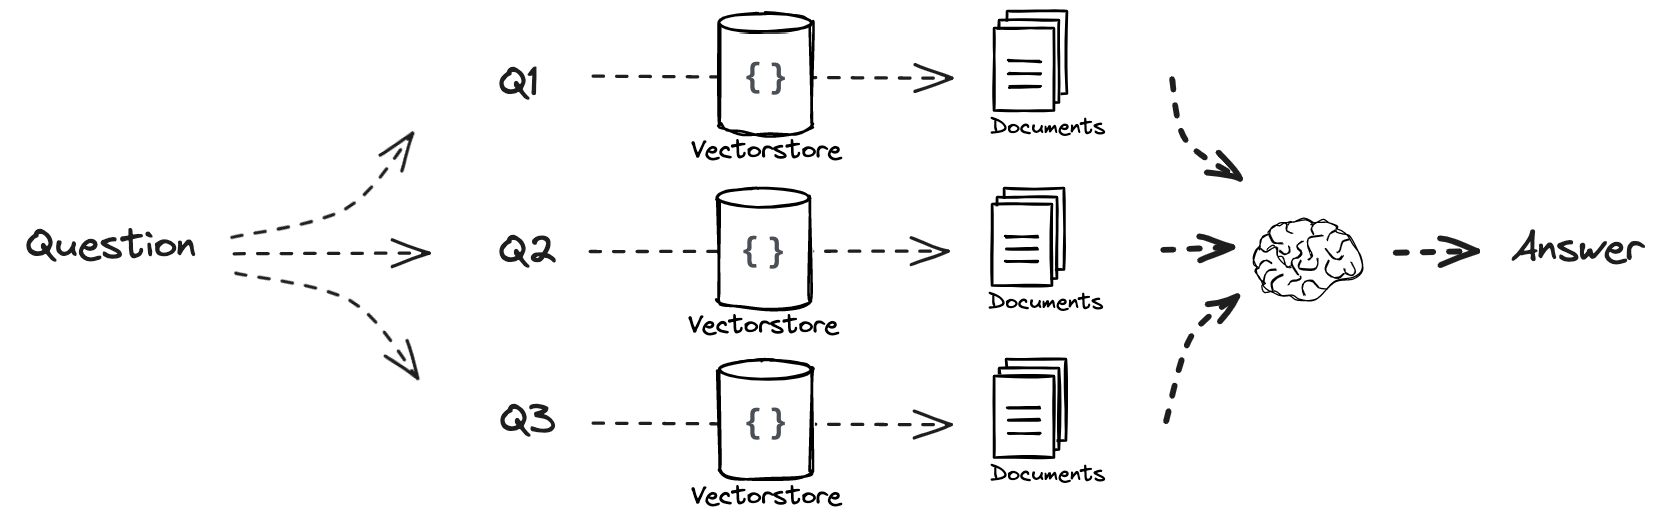



# 下準備

In [2]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import MarkdownHeaderTextSplitter,RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

#Document load
loader = DirectoryLoader("../datasets/company_documents_dataset_1/", glob="**/*.txt",recursive=True)
raw_docs = loader.load()

# Document split
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, 
    return_each_line=False,
    strip_headers = False 
)
docs = []
for raw_doc in raw_docs:
    source = raw_doc.metadata["source"]
    spilited_docs = markdown_splitter.split_text(raw_doc.page_content)
    for doc in spilited_docs:
        doc.metadata["source"] = source#metadataにsourceを加える
    docs = docs + spilited_docs
markdown_splited_docs = docs
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 700,chunk_overlap=50)
docs = text_splitter.split_documents(docs)

# Embd
vectorstore = Chroma.from_documents(persist_directory="./vecstore/index", documents=docs, embedding=OpenAIEmbeddings())

#llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0)

# retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})



# Step back prompting

In [7]:
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain.callbacks.tracers import ConsoleCallbackHandler

# rewrite chain
rewrite_prompt=PromptTemplate.from_template(
"""
次の質問を、広い視野で見た内容に書き換えて下さい。
たとえば"○○さんの誕生日はいつですか？"のような質問の場合は"○○さんのこれまでの人生を教えて下さい"の様にします。

###質問###
{question}

書き換えた質問:
"""
)
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0)
rewrite_chain = rewrite_prompt|llm|StrOutputParser()

# rag chain
rag_prompt = PromptTemplate(
    input_variables=["context","question"],
    template="""以下の参考用のテキストの一部を参照して、Questionに回答してください。もし参考用のテキストの中に回答に役立つ情報が含まれていなければ、分からない、と答えてください。
{context}
Question: {question}
Answer: """
)
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0)
rag_chain = (
    {
        "question":RunnablePassthrough(),
        "context":rewrite_chain|retriever #rewirte_chainで生成した文章を使う
    }
    |rag_prompt
    |llm
    |StrOutputParser()
  
)


question = "会社の住所は？"
print("【rewrite_chainの動作確認】")
print(rewrite_chain.invoke({"question":question}))
print("")
handler = ConsoleCallbackHandler()
answer = rag_chain.invoke({"question":question},{"callbacks":[handler]})
print("【質問と回答】")
print(f"question:{question},  answer:{answer}")



【rewrite_chainの動作確認】
会社の立地や拠点について教えてください。

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "会社の住所は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context>] Entering Chain run with input:
{
  "question": "会社の住所は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnablePassthrough] Entering Chain run with input:
{
  "question": "会社の住所は？"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "question": "会社の住所は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 4:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "会社の住所は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 4:chain:RunnableSequence > 5:prompt:PromptTemplate] Entering Prompt run with input:
{
  "question": "会

[llm/end] [1:chain:RunnableSequence > 10:llm:ChatOpenAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "分からない。",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "分からない。",
            "additional_kwargs": {}
          }
        }
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "completion_tokens": 5,
      "prompt_tokens": 4243,
      "total_tokens": 4248
    },
    "model_name": "gpt-3.5-turbo",
    "system_fingerprint": "fp_69829325d0"
  },
  "run": null
}
[chain/start] [1:chain:RunnableSequence > 11:parser:StrOutputParser] Entering Parser run with input:
[inputs]
[chain/end] [1:chain:RunnableSequence > 11:

In [6]:
prompt = PromptTemplate(
    input_variables=["context","question"],
    template="""以下の参考用のテキストの一部を参照して、Questionに回答してください。もし参考用のテキストの中に回答に役立つ情報が含まれていなければ、分からない、と答えてください。
{context}
Question: {question}
Answer: """
)

rag_chain = (
    {
        "question":RunnablePassthrough(),
        "context":retriever 
    }
    |prompt
    |llm
    |StrOutputParser()
)
question = "会社の住所は？"
print("---------------------------------------Step back promptingなしの場合---------------------------------------")
print("")
handler = ConsoleCallbackHandler()
answer = rag_chain.invoke(question,{"callbacks":[handler]})
print("【質問と回答】")
print(f"question:{question},  answer:{answer}")


print("")
print("")
print("")


---------------------------------------Step back promptingなしの場合---------------------------------------

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "会社の住所は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context>] Entering Chain run with input:
{
  "input": "会社の住所は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "会社の住所は？"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "会社の住所は？"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context>] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:RunnableSequence > 5:prompt:PromptTemplate] Entering Prompt run with input:
[inputs]
[chain/end] [1:chain:RunnableSequence > 5:prompt:PromptTemplate] s] Exiting

# Rewrite-Retrieve-Read

[論文](https://arxiv.org/pdf/2305.14283.pdf?ref=blog.langchain.dev)


ユーザーの質問を検索に適した文章に書き換える方法。

社内ドキュメントをインターネット検索の形式に直すのが、向いてるかはわからないが、例として変換してみる。

Web検索を使ったRAGを構築する場合、このテクニックは入れておいた方が良さそう。

In [10]:
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain.callbacks.tracers import ConsoleCallbackHandler


rewrite_prompt=PromptTemplate.from_template(
"""
Provide a better search query for web search engine to answer the given question, \
just 1 answer, no quote, end the each queries with ’**’.
Question: 
{question}
Answer:
"""
)
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0)
rewrite_chain = rewrite_prompt|llm|StrOutputParser()

# rag chain
rag_prompt = PromptTemplate(
    input_variables=["context","question"],
    template="""以下の参考用のテキストの一部を参照して、Questionに回答してください。もし参考用のテキストの中に回答に役立つ情報が含まれていなければ、分からない、と答えてください。
{context}
Question: {question}
Answer: """
)
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0)
rag_chain = (
    {
        "question":RunnablePassthrough(),
        "context":rewrite_chain|retriever #rewirte_chainで生成した文章を使う
    }
    |rag_prompt
    |llm
    |StrOutputParser()
  
)



question = "時間外手当の計算方法は？"

print("【rewrite_chainの動作確認】")
print(rewrite_chain.invoke({"question":question}))
print("")
handler = ConsoleCallbackHandler()
answer = rag_chain.invoke({"question":question},{"callbacks":[handler]})
print("【質問と回答】")
print(f"question:{question},  answer:{answer}")



【rewrite_chainの動作確認】
時間外手当 計算方法**

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "時間外手当の計算方法は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context>] Entering Chain run with input:
{
  "question": "時間外手当の計算方法は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnablePassthrough] Entering Chain run with input:
{
  "question": "時間外手当の計算方法は？"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "question": "時間外手当の計算方法は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 4:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "時間外手当の計算方法は？"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 4:chain:RunnableSequence > 5:prompt:PromptTemplate] Entering Prompt run with input:
{

[llm/end] [1:chain:RunnableSequence > 10:llm:ChatOpenAI] [2.10s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "時間外手当の計算方法は、（基本給／１か月の平均所定労働時間数）×１．２５×時間外労働時間数である。",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "時間外手当の計算方法は、（基本給／１か月の平均所定労働時間数）×１．２５×時間外労働時間数である。",
            "additional_kwargs": {}
          }
        }
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "completion_tokens": 50,
      "prompt_tokens": 2089,
      "total_tokens": 2139
    },
    "model_name": "gpt-3.5-turbo",
    "system_fingerprint": "fp_69829325d0"
  },
  "run": null
}
[chain/start] [1:chain:RunnableSequence > 11:parser:StrOutput

# Query expansion(Multi-query retriever)
LLM を使用してクエリ拡張を実現し、特定のユーザー入力クエリに対してさまざまな観点から複数のクエリを生成

５つのドキュメント取得する→retrieverから検索→重複してるドキュメントを削除する

### prompt

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.callbacks.tracers import ConsoleCallbackHandler

template = """AI言語モデルアシスタントとして、与えられたユーザーの質問から関連するドキュメントをベクトルデータベースから検索するために、その質問の異なる5つのバージョンを生成することがあなたの任務です。質問に対する複数の視点を生成することで、距離ベースの類似性検索のいくつかの制限を克服するのをユーザーに助けます。
これらの代替質問を改行で区切って提供してください。オリジナルの質問: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))#改行コードごとにsplitで区切ってリストにする
)

#動作確認
question = "会社の住所を教えて"
handler = ConsoleCallbackHandler()
result = generate_queries.invoke({"question":question},{"callbacks":[handler]})
print("結果:",result)

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "会社の住所を教えて"
}
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "会社の住所を教えて"
}
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
{
  "lc": 1,
  "type": "constructor",
  "id": [
    "langchain",
    "prompts",
    "chat",
    "ChatPromptValue"
  ],
  "kwargs": {
    "messages": [
      {
        "lc": 1,
        "type": "constructor",
        "id": [
          "langchain",
          "schema",
          "messages",
          "HumanMessage"
        ],
        "kwargs": {
          "content": "AI言語モデルアシスタントとして、与えられたユーザーの質問から関連するドキュメントをベクトルデータベースから検索するために、その質問の異なる5つのバージョンを生成することがあなたの任務です。質問に対する複数の視点を生成することで、距離ベースの類似性検索のいくつかの制限を克服するのをユーザーに助けます。\nこれらの代替質問を改行で区切って提供してください。オリジナルの質問: 会社の住所を教えて",
          "additional_kwargs": {}
        }
      }
    ]
  }
}
[llm/start] [1:chain:RunnableSe

###  Retrieve

In [13]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ 重複しているdocumentを削除する """
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]

question = "会社の休日はどのように設定されているか教えて"
retrieval_chain = generate_queries | retriever.map() | get_unique_union#retireve.map()にする理由はretrieveはstrしか受け入れられないため。generate_queriesのoutputはlistである。
handler = ConsoleCallbackHandler()
docs = retrieval_chain.invoke({"question":question},{"callbacks":[handler]})
print(docs)

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "会社の休日はどのように設定されているか教えて"
}
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "会社の休日はどのように設定されているか教えて"
}
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
{
  "lc": 1,
  "type": "constructor",
  "id": [
    "langchain",
    "prompts",
    "chat",
    "ChatPromptValue"
  ],
  "kwargs": {
    "messages": [
      {
        "lc": 1,
        "type": "constructor",
        "id": [
          "langchain",
          "schema",
          "messages",
          "HumanMessage"
        ],
        "kwargs": {
          "content": "AI言語モデルアシスタントとして、与えられたユーザーの質問から関連するドキュメントをベクトルデータベースから検索するために、その質問の異なる5つのバージョンを生成することがあなたの任務です。質問に対する複数の視点を生成することで、距離ベースの類似性検索のいくつかの制限を克服するのをユーザーに助けます。\nこれらの代替質問を改行で区切って提供してください。オリジナルの質問: 会社の休日はどのように設定されているか教えて",
          "additional_kwargs": {}
        }
      }
    

/Users/rokuroyamaki/anaconda3/envs/llm/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:86: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


### rag chain

In [15]:
from operator import itemgetter
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough


# rag chain
rag_prompt = PromptTemplate(
    input_variables=["context","question"],
    template="""以下の参考用のテキストの一部を参照して、Questionに回答してください。もし参考用のテキストの中に回答に役立つ情報が含まれていなければ、分からない、と答えてください。
{context}
Question: {question}
Answer: """
)
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0)
rag_chain = (
    {
        "question":itemgetter("question"),
        "context":retrieval_chain
    }
    |rag_prompt
    |llm
    |StrOutputParser()
  
)
question = "会社の住所を教えて"
handler = ConsoleCallbackHandler()
rag_chain.invoke({"question":question},{"callbacks":[handler]})

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "会社の住所を教えて"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context>] Entering Chain run with input:
{
  "question": "会社の住所を教えて"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnableLambda] Entering Chain run with input:
{
  "question": "会社の住所を教えて"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 3:chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": "会社の住所を教えて"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 4:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "会社の住所を教えて"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<question,context> > 4:chain:RunnableSequence > 5:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "会社の住所を教えて"
}
[chain/end] [1:chain:Runnable

[llm/end] [1:chain:RunnableSequence > 17:llm:ChatOpenAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "東京都中央区架空町1ー1ー1",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "東京都中央区架空町1ー1ー1",
            "additional_kwargs": {}
          }
        }
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "completion_tokens": 18,
      "prompt_tokens": 590,
      "total_tokens": 608
    },
    "model_name": "gpt-3.5-turbo",
    "system_fingerprint": "fp_69829325d0"
  },
  "run": null
}
[chain/start] [1:chain:RunnableSequence > 18:parser:StrOutputParser] Entering Parser run with input:
[inputs]
[chain/end] [1:chain:Runnabl

'東京都中央区架空町1ー1ー1'

In [16]:
rag_chain.get_graph().print_ascii()

                   +---------------------------------+                        
                   | Parallel<question,context>Input |                        
                   +---------------------------------+                        
                        ****                  ****                            
                    ****                          ****                        
                  **                                  ****                    
   +--------------------+                                 **                  
   | ChatPromptTemplate |                                  *                  
   +--------------------+                                  *                  
              *                                            *                  
              *                                            *                  
              *                                            *                  
       +------------+                               

# Reference
https://note.com/npaka/n/n62cd25213679#0d139f77-ae3c-419f-8396-533d9917c63e

https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_5_to_9.ipynb

https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb

https://techblog.cccmkhd.co.jp/entry/2024/01/23/142346
